In [108]:
from pathlib import Path
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
import pdb
import pickle
import numpy as np
from typing_extensions import Annotated
import time

import sys
sys.path.append(r"C:\Users\bjieu\git\MBNpy")
from mbnpy import model, config, trans, variable, brc, branch, cpm, inference

HOME = Path().resolve()

%matplotlib inline

# Version info: v1

- Consider capacity--the system function considers only edges that have an equal or greater capacity than a target capacity (e.g. 50, 75, 100).
- Run BRC to identify survival and failure conditions.
- The travel time should not take longer than (original time) + (thres), i.e. the failure definition is in terms of absolute value.

# User inputs

System event definition

In [109]:
key = 'York_Merredin'
#thres = cfg.data['THRESHOLD'] # if it takes longer than this, we consider the od pair is disconnected
thres = 90*60 # (sec) The travel time should not take longer than (original time) + (thres), i.e. the failure definition is in terms of absolute value.
min_edge_capa = 75 # min edge capacity required

Configuation data

In [110]:
# load data
cfg = config.Config(HOME.joinpath('./config.json'))
od_pair = cfg.infra['ODs'][key]
print(f"Selected OD pair: {od_pair}")

scenario to be added later
Selected OD pair: ('York', 'Merredin')


Failure probabilities of each bridge (modelled as nodes in the graph)

Here we assume binary states for each edge, assuming that 
connectivity is the most concerned factor for emergency activities
i.e. congestion is not of concern

In [111]:
file_dmg = "./avg_gmf_69_dmg.csv"
probs_all = pd.read_csv(file_dmg, index_col=0)
probs_all.index = probs_all.index.astype('str')
probs_all['failure'] = probs_all['Extensive'] + probs_all['Complete']
probs_all = probs_all.to_dict('index')

probs = {k: {0: v['failure'], 1: 1.0-v['failure']} for k, v in probs_all.items() if k in varis.keys()}
print(probs)

{'0277': {0: 0.0944034037193644, 1: 0.9055965962806356}, '0278': {0: 0.0053592467109883, 1: 0.9946407532890117}, '0279': {0: 0.0051202648238796, 1: 0.9948797351761204}, '0280': {0: 0.0014664184445196, 1: 0.9985335815554804}, '0281': {0: 0.0011574244236495, 1: 0.9988425755763505}, '0282': {0: 0.0027101770812885, 1: 0.9972898229187115}, '0283': {0: 0.0016462808932509, 1: 0.9983537191067491}, '0284': {0: 0.0587751195665464, 1: 0.9412248804334536}, '0285': {0: 0.0013042514493005, 1: 0.9986957485506995}, '0286': {0: 0.0013118952568398, 1: 0.9986881047431602}, '0287': {0: 0.0510761420465468, 1: 0.9489238579534532}, '0288': {0: 0.0013352206913295, 1: 0.9986647793086705}, '0289': {0: 0.00048799105003709476, 1: 0.999512008949963}, '0290': {0: 0.169447689715327, 1: 0.830552310284673}, '0291': {0: 0.0679430607421744, 1: 0.9320569392578256}, '0299': {0: 0.0010939813132391, 1: 0.9989060186867609}, '0300': {0: 0.039631509935041206, 1: 0.9603684900649588}, '0301': {0: 0.0007713046230969475, 1: 0.9992

# Modelling

The Bayesian network consists of two layers, one representing bridges and one the system event. <br>
The system event represents the time it takes from origin to destination.


Component events

In [112]:
# variables
varis = {}
cpms = {}
for k, v in cfg.infra['nodes'].items():
    if k in probs: # k is bridge
        varis[k] = variable.Variable(name=k, values = ['f', 's'])
        cpms[k] = cpm.Cpm(variables = [varis[k]], no_child=1,
                            C = np.array([0, 1]).T, p = [probs[k][0], probs[k][1]])

Network analysis

In [113]:
print(G.edges[('0638', '4815')])

{'label': '1', 'weight': 469, 'key': '1', 'capacity': 75}


In [114]:
G = cfg.infra['G']
for u, v, data in G.edges(data=True):
    edge_key = data.get('key', (u, v))
    if edge_key in cfg.infra['edges']:
        data['capacity'] = cfg.infra['edges'][edge_key]['link_capacity']
    else:
        data['capacity'] = np.inf

d_time_itc0 = nx.shortest_path_length(G, source=od_pair[0], target=od_pair[1], weight='weight')
print(d_time_itc0)

6547


In [115]:
G_capa = G.copy()
edges_to_remove = [(u,v) for u,v,data in G.edges(data=True) if data.get('capacity', np.inf) < min_edge_capa]
G_capa.remove_edges_from(edges_to_remove)

print(f"Removed edges: {edges_to_remove}")

d_time_itc = nx.shortest_path_length(G_capa, source=od_pair[0], target=od_pair[1], weight='weight')
print(f"Shortest time for the specified edge capacity: {d_time_itc}")

Removed edges: [('0597', 'Kellerberrin'), ('0597', '0596'), ('0597', '0598'), ('Kellerberrin', '0596'), ('Kellerberrin', '0641'), ('Kellerberrin', '4151'), ('0286', '4166A'), ('4166A', 'York'), ('York', '4184'), ('York', '4156'), ('Northam', '0613'), ('0639', 'Meckering'), ('0639', '0765'), ('0639', 'Merredin'), ('Meckering', '0284'), ('Cunderdin', '1065'), ('1065', '0714'), ('0714', '0715'), ('0714', '0730'), ('0715', '0717'), ('0717', '5093'), ('0717', '0596'), ('5093', '0305'), ('5093', '5281'), ('0612', '0613'), ('Merredin', '0641'), ('Merredin', '5100A'), ('Merredin', '0602'), ('0729', '0730'), ('0596', '0592'), ('4556A', '4151'), ('4556A', '0288'), ('0765', '0637'), ('5281', '5099A'), ('5099A', '6223A'), ('6223A', '5100A'), ('Wooroloo', '4527'), ('0631A', '0632A'), ('0632A', '0633A'), ('0633A', '0634'), ('0634', '0637'), ('0579', '0580'), ('0580', '0897'), ('0897', '0898'), ('0898', '0589'), ('0589', '0592'), ('0598', '0602')]
Shortest time for the specified edge capacity: 8037


In [116]:
def sys_fun(comps_st, G, threshold, od_pair, d_time_itc, min_edge_capa=75):
    G_tmp = G.copy()
    
    # Remove edges with capacity lower than min_edge_capacity
    edges_to_remove = [(u,v) for u,v,data in G.edges(data=True) if data.get('capacity', np.inf) < min_edge_capa]
    G_tmp.remove_edges_from(edges_to_remove)

    for br, st in comps_st.items():
        if st == 0:
            for neigh in G_tmp.neighbors(br):
                G_tmp[br][neigh]['weight'] = float('inf')

    d_time = nx.shortest_path_length(G_tmp, source=od_pair[0], target=od_pair[1], weight='weight')

    if d_time > threshold + d_time_itc:
        sys_st = 'f'
        min_comps_st = None
    else:
        sys_st = 's'  

        path = nx.shortest_path(G_tmp, source=od_pair[0], target=od_pair[1], weight='weight')
        min_comps_st = {node: 1 for node in path if node in comps_st.keys()}

    return d_time, sys_st, min_comps_st
    


In [125]:
sf_brc = lambda comps_st: sys_fun(comps_st, G, thres, od_pair, d_time_itc, min_edge_capa=min_edge_capa)

brs, rules, sys_res, monitor = brc.run(probs, sf_brc,
                                       pf_bnd_wr=0.01, max_rules=50, surv_first=True,
                                       active_decomp=10, display_freq=5)

[System function runs 5]..
The # of found non-dominated rules (f, s): 4 (1, 3)
Probability of branchs (f, s, u): (8.0708e-02, 7.17e-01, 2.0233e-01)
The # of branches (f, s, u), (min, avg) len of rf: 1409 (2, 58, 1349), (2, 2.00)
Elapsed seconds (average per round): 4.05e+00 (8.09e-01)
[System function runs 10]..
The # of found non-dominated rules (f, s): 9 (5, 4)
Probability of branchs (f, s, u): (1.4507e-01, 7.55e-01, 9.9494e-02)
The # of branches (f, s, u), (min, avg) len of rf: 2485 (88, 101, 2296), (2, 2.40)
Elapsed seconds (average per round): 1.34e+01 (1.34e+00)
[System function runs 15]..
The # of found non-dominated rules (f, s): 14 (9, 5)
Probability of branchs (f, s, u): (1.6377e-01, 7.78e-01, 5.8265e-02)
The # of branches (f, s, u), (min, avg) len of rf: 1476 (98, 177, 1201), (1, 2.11)
Elapsed seconds (average per round): 1.72e+01 (1.15e+00)
[System function runs 20]..
The # of found non-dominated rules (f, s): 19 (14, 5)
Probability of branchs (f, s, u): (1.8162e-01, 7.78e-

In [126]:
fpath_rule = f"./rules_{od_pair[0]}_{od_pair[1]}_v1.json"
with open(fpath_rule, "w") as f:
    json.dump(rules, f, indent=4)

fpath_br = f"./brs_{od_pair[0]}_{od_pair[1]}_v1.parquet"
branch.save_brs_to_parquet(brs, fpath_br)

fpath_mon = f"./monitor_{od_pair[0]}_{od_pair[1]}_v1.json"
with open(fpath_mon, "w") as f:
    json.dump(monitor, f, indent=4)

fpath_res = f"./sys_res_{od_pair[0]}_{od_pair[1]}_v1.json"
sys_res.to_json( fpath_res, orient='records', lines=True )



In [127]:
varis['sys'] = variable.Variable(name='sys', values=['f','s','u'])

Csys = branch.get_cmat(brs, {x: varis[x] for x in probs})
psys = np.ones((Csys.shape[0],1))

cpms['sys'] = cpm.Cpm(variables=[varis['sys']]+[varis[x] for x in probs], no_child=1, C=Csys, p=psys)

with open(f'./varis_{od_pair[0]}_{od_pair[1]}_v1.pickle', 'wb') as f:
    pickle.dump(varis, f)
with open(f'./cpms_{od_pair[0]}_{od_pair[1]}_v1.pickle', 'wb') as f:
    pickle.dump(cpms, f)

*Appendix: try different min_edge_capa

- min_edge_capa = 50

In [120]:
sf_brc = lambda comps_st: sys_fun(comps_st, G, thres, od_pair, d_time_itc, min_edge_capa=50)

brs, rules, sys_res, monitor = brc.run(probs, sf_brc,
                                       pf_bnd_wr=0.00, max_rules=10, surv_first=True,
                                       active_decomp=10, display_freq=5)

[System function runs 5]..
The # of found non-dominated rules (f, s): 4 (0, 4)
Probability of branchs (f, s, u): (0.0000e+00, 9.96e-01, 3.8945e-03)
The # of branches (f, s, u), (min, avg) len of rf: 207 (0, 36, 171), (0, 0.00)
Elapsed seconds (average per round): 2.91e-01 (5.83e-02)
[System function runs 10]..
The # of found non-dominated rules (f, s): 9 (0, 9)
Probability of branchs (f, s, u): (0.0000e+00, 1.00e+00, 5.0653e-05)
The # of branches (f, s, u), (min, avg) len of rf: 14146 (0, 1056, 13090), (0, 0.00)
Elapsed seconds (average per round): 2.98e+01 (2.98e+00)

*Final decomposition is completed with 5144 branches (originally 5144 branches).

***Analysis completed with f_sys runs 11: out_flag = max_rules***
The # of found non-dominated rules (f, s): 10 (0, 10)
Probability of branchs (f, s, u): (0.0000e+00, 1.00e+00, 2.8384e-05)
The # of branches (f, s, u), (min, avg) len of rf: 5144 (0, 751, 4393), (0, 0.00)
Elapsed seconds (average per round): 7.00e+01 (5.83e+00)


Result: much more likely to survive.

- min_edge_capa = 100

In [122]:
sf_brc = lambda comps_st: sys_fun(comps_st, G, thres, od_pair, d_time_itc, min_edge_capa=100)

brs, rules, sys_res, monitor = brc.run(probs, sf_brc,
                                       pf_bnd_wr=0.00, max_rules=10, surv_first=True,
                                       active_decomp=10, display_freq=5)

[System function runs 5]..
The # of found non-dominated rules (f, s): 4 (2, 2)
Probability of branchs (f, s, u): (1.1805e-01, 6.99e-01, 1.8339e-01)
The # of branches (f, s, u), (min, avg) len of rf: 438 (28, 16, 394), (2, 2.00)
Elapsed seconds (average per round): 1.00e+00 (2.00e-01)
[System function runs 10]..
The # of found non-dominated rules (f, s): 9 (6, 3)
Probability of branchs (f, s, u): (1.6484e-01, 7.62e-01, 7.3517e-02)
The # of branches (f, s, u), (min, avg) len of rf: 1544 (678, 39, 827), (1, 1.83)
Elapsed seconds (average per round): 6.38e+00 (6.38e-01)

*Final decomposition is completed with 284 branches (originally 284 branches).

***Analysis completed with f_sys runs 11: out_flag = max_rules***
The # of found non-dominated rules (f, s): 10 (7, 3)
Probability of branchs (f, s, u): (1.7398e-01, 7.62e-01, 6.4377e-02)
The # of branches (f, s, u), (min, avg) len of rf: 284 (8, 17, 259), (1, 1.86)
Elapsed seconds (average per round): 8.13e+00 (6.77e-01)


Result: more likely to fail.

# Inference

Load data

In [133]:
with open(f'./varis_{od_pair[0]}_{od_pair[1]}_v1.pickle', 'rb') as f:
    varis = pickle.load(f)
with open(f'./cpms_{od_pair[0]}_{od_pair[1]}_v1.pickle', 'rb') as f:
    cpms = pickle.load(f)
cfg = config.Config(HOME.joinpath('./config.json'))

fpath_rule = f"./rules_{od_pair[0]}_{od_pair[1]}_v1.json"
with open(fpath_rule, "r") as f:
    rules = json.load(f)


scenario to be added later


## Update component prob

In [135]:
file_dmg = "./avg_gmf_69_dmg.csv"
probs_all = pd.read_csv(file_dmg, index_col=0)
probs_all.index = probs_all.index.astype('str')
probs_all['failure'] = probs_all['Extensive'] + probs_all['Complete']
probs_all = probs_all.to_dict('index')

probs = {k: {0: v['failure'], 1: 1.0-v['failure']} for k, v in probs_all.items() if k in varis.keys()}
print(probs)

# update component CPMs' probabilities
for k, v in probs.items():
    cpms[k].p = np.array([v[0], v[1]]).T

{'0277': {0: 0.0944034037193644, 1: 0.9055965962806356}, '0278': {0: 0.0053592467109883, 1: 0.9946407532890117}, '0279': {0: 0.0051202648238796, 1: 0.9948797351761204}, '0280': {0: 0.0014664184445196, 1: 0.9985335815554804}, '0281': {0: 0.0011574244236495, 1: 0.9988425755763505}, '0282': {0: 0.0027101770812885, 1: 0.9972898229187115}, '0283': {0: 0.0016462808932509, 1: 0.9983537191067491}, '0284': {0: 0.0587751195665464, 1: 0.9412248804334536}, '0285': {0: 0.0013042514493005, 1: 0.9986957485506995}, '0286': {0: 0.0013118952568398, 1: 0.9986881047431602}, '0287': {0: 0.0510761420465468, 1: 0.9489238579534532}, '0288': {0: 0.0013352206913295, 1: 0.9986647793086705}, '0289': {0: 0.00048799105003709476, 1: 0.999512008949963}, '0290': {0: 0.169447689715327, 1: 0.830552310284673}, '0291': {0: 0.0679430607421744, 1: 0.9320569392578256}, '0299': {0: 0.0010939813132391, 1: 0.9989060186867609}, '0300': {0: 0.039631509935041206, 1: 0.9603684900649588}, '0301': {0: 0.0007713046230969475, 1: 0.9992

## Paths' survival probabilities

In [145]:
print(sys_res.columns)

Index(['sys_val', 'comp_st', 'comp_st_min'], dtype='object')


In [159]:
# Path times
rules_time = []
for r in rules['s']:
    path_time = sys_res[sys_res['comp_st_min']==r]['sys_val'].values
    rules_time.append(float(path_time))

print(rules_time)

sort_idx = sorted(range(len(rules_time)), key=lambda i:rules_time[i], reverse=False)
rules_s_sorted = [rules['s'][i] for i in sort_idx]
print(rules_s_sorted)

rules_time_sorted = [rules_time[i] for i in sort_idx]
print(rules_time_sorted)

rules_prob = []
for r in rules_s_sorted:
    p_r = 1.0
    for k in r:
        p_r *= cpms[k].p[1]
    rules_prob.append(float(p_r))
print(rules_prob)

[8037.0, 10602.0, 8654.0, 9176.0, 11203.0]
[{'0290': 1, '0289': 1, '0288': 1, '0287': 1, '0286': 1, '0285': 1, '0284': 1, '0283': 1, '0282': 1, '0281': 1, '0280': 1, '0279': 1, '0278': 1, '0277': 1, '0613': 1, '1149': 1, '1150': 1, '1153': 1, '1154': 1, '0617': 1, '1006': 1, '1007': 1, '1050': 1, '0627': 1}, {'0290': 1, '0289': 1, '0288': 1, '0287': 1, '0286': 1, '0285': 1, '0284': 1, '0283': 1, '0282': 1, '0281': 1, '0280': 1, '0279': 1, '0278': 1, '0277': 1, '0612': 1, '9186': 1, '1469': 1, '1468': 1, '1504': 1, '1467': 1, '1466': 1, '1465': 1, '1464': 1, '1463': 1, '9187': 1, '1149': 1, '1150': 1, '1153': 1, '1154': 1, '0617': 1, '1006': 1, '1007': 1, '1050': 1, '0627': 1}, {'0290': 1, '0289': 1, '0288': 1, '0287': 1, '0286': 1, '0285': 1, '0284': 1, '0283': 1, '4156': 1, '4154': 1, '4815': 1, '0612': 1, '9186': 1, '1469': 1, '1468': 1, '1504': 1, '1467': 1, '1466': 1, '1465': 1, '1464': 1, '1463': 1, '9187': 1, '1149': 1, '1150': 1, '1153': 1, '1154': 1, '0617': 1, '1006': 1, '1007

C:\Users\bjieu\AppData\Local\Temp\ipykernel_21296\403598323.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rules_time.append(float(path_time))
C:\Users\bjieu\AppData\Local\Temp\ipykernel_21296\403598323.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rules_prob.append(float(p_r))


In [206]:
print(rules_time_sorted)

[8037.0, 8654.0, 9176.0, 10602.0, 11203.0]


In [207]:
# System failure probability calculation
Msys = inference.prod_Msys_and_Mcomps(cpms['sys'], [cpms[k] for k in probs.keys()]) # this is faster than var_elim (given that there are only a system event and component events to compute)
Msys = Msys.sum([varis[k] for k in probs])
P_S0_low = Msys.get_prob([varis['sys']], [0])
P_S0_up = 1.0 - Msys.get_prob([varis['sys']], [1])

print(Msys)
print(f"P(S=0) in ({P_S0_low}, {P_S0_up})")

Cpm(variables=['sys'],
no_child=1,
C=[[1]
 [0]
 [2]],
p=[[0.78255522]
 [0.21097413]
 [0.00647065]],
)
P(S=0) in (0.21097413246523927, 0.21744478277526424)


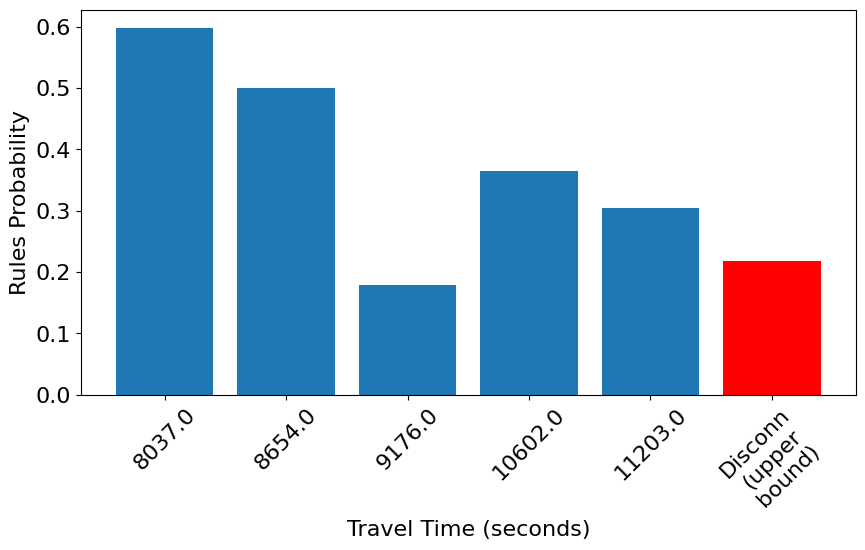

In [217]:
fsz = 16
colors = ['C0'] * len(rules_prob) + ['red']

plt.figure(figsize=(10, 5))
plt.bar(
    range(len(rules_prob) + 1),
    rules_prob + [P_S0_up],
    tick_label=rules_time_sorted + ['Disconn\n(upper\nbound)'],
    color=colors
)
plt.xlabel("Travel Time (seconds)", fontsize=fsz)
plt.ylabel("Rules Probability", fontsize=fsz)
plt.xticks(fontsize=fsz, rotation=45)
plt.yticks(fontsize=fsz)
plt.show()

## Component importance measures

$CPIM = P( X_n = 0 | S = 0 )$, where <br>
$P( X_n = 0, S = 0 ) \in [\bar{P}( X_n = 0, S = 0 ), 1-\bar{P}( X_n = 1, S = 0 )-\bar{P}( X_n = 0, S = 1 )-\bar{P}( X_n = 1, S = 1 )]$ and <br>
$P( S = 0 ) \in [\bar{P}( S = 0 ), 1-\bar{P}( S = 1 )]$.

$\bar{P}(\cdot)$ denotes the probability obtained from incomplete identification of rules by BRC.

In [185]:
P_Xn0_S0 = {}
for k in probs.keys():
    Msys_k = inference.prod_Msys_and_Mcomps(cpms['sys'], [cpms[k2] for k2 in probs.keys() if k2!=k]) # this is faster than var_elim (given that there are only a system event and component events to compute)
    Msys_k = Msys_k.sum([varis['sys']], False)
    Msys_k = Msys_k.product(cpms[k])
    
    p_num_low = Msys_k.get_prob([varis['sys'], varis[k]], [0, 0])
    p_num_up = 1.0 - Msys_k.get_prob([varis['sys'], varis[k]], [0, 1]) - Msys_k.get_prob([varis['sys'], varis[k]], [1, 0]) - Msys_k.get_prob([varis['sys'], varis[k]], [1, 1])

    p_int = (p_num_low / P_S0_up, p_num_up / P_S0_low)
    P_Xn0_S0[k] = p_int

In [205]:
P_Xn0_S0_sorted = dict(sorted(P_Xn0_S0.items(), key=lambda item: item[1][0], reverse=True))


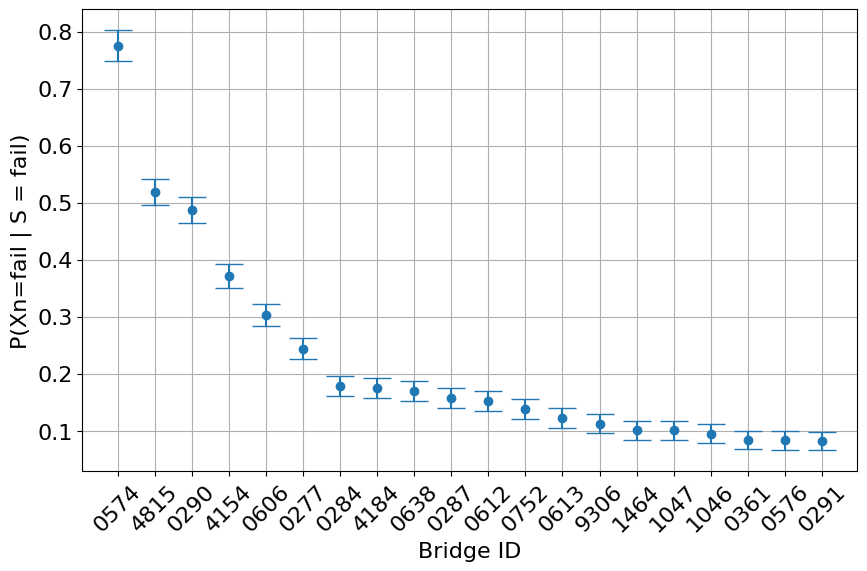

In [204]:
# visualisation
P_Xn0_S0_to_draw = list(P_Xn0_S0_sorted.items())[:20]

# Extract labels, midpoints, and bounds
labels = [k for k, _ in P_Xn0_S0_to_draw]
low = [v[0] for _, v in P_Xn0_S0_to_draw]
high = [v[1] for _, v in P_Xn0_S0_to_draw]
mid = [(l + h) / 2 for l, h in zip(low, high)]
error = [(m - l, h - m) for m, l, h in zip(mid, low, high)]
lower_err, upper_err = zip(*error)

# Plot as vertical error bars
plt.figure(figsize=(10, 6))
plt.errorbar(x=range(len(labels)), y=mid, 
             yerr=[lower_err, upper_err], 
             fmt='o', capsize=10)

# Formatting
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, fontsize=fsz)
plt.ylabel("P(Xn=fail | S = fail)", fontsize=fsz)
plt.xlabel("Bridge ID", fontsize=fsz)
plt.yticks(fontsize=fsz)
plt.grid(True)
plt.show()